<a href="https://colab.research.google.com/github/jaderAdriel/Clorofila-a/blob/main/Projeto_pibic_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Bilbiotecas { display-mode: "form" }
!pip install --upgrade gspread
!pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from gspread import *
import numpy as np

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


Panilha reservatorio Ceraima: [CND-CER-002](https://docs.google.com/spreadsheets/d/16gMgMV5wRAF83w7i_q9JwA03kGQprFkMjQojLgNDVtA/edit?usp=sharing)

Panilha reservatorio Ilheus: [LES-IGP-001](https://docs.google.com/spreadsheets/d/1xK1tuD3eTHktwVzsmqZEcFKcjut-eak2E21AxtdTUek/edit?ouid=115855923033913247098&usp=sheets_home&ths=true)

In [2]:
#@title Insira a url da panilha e o nome do reservatorio e o parâmetro { run: "auto", form-width: "50%", display-mode: "form" }

url1 = "https://docs.google.com/spreadsheets/d/16gMgMV5wRAF83w7i_q9JwA03kGQprFkMjQojLgNDVtA/edit#gid=367972063" #@param {type:"string"}
reservatory1 = "CND-CER-002" #@param {type:"string"}
url2 = "https://docs.google.com/spreadsheets/d/1xK1tuD3eTHktwVzsmqZEcFKcjut-eak2E21AxtdTUek/edit#gid=347055721" #@param {type:"string"}
reservatory2 = "LES-IGP-001" #@param {type:"string"}



In [254]:
#@title  { run: "auto", display-mode: "form" }
#@title  { run: "auto" }
#@title  { form-width: "50%" }
#@markdown Select if you want compare parametes on the same reservoirs, compare same parameter on diferents reservoirs or dont compare
compare = "MostConcentradeCompaign" #@param ["Parameters", "Reservoirs", "Interval", "MostConcentradeCompaign"]
parameter1 = "DBO" #@param ["Clorofila a", "Colif. termo", "Condutividade", "Salinidade", "Sólidos em suspensão", "Sólidos totais", "STD", "Temperatura", "Turbidez", "Alcalinidade total", "DBO", "DQO", "Nitrogênio Nitrato", "N-NH3", "N Total", "OD", "pH", "P Total", "% Saturação de Oxigênio Dissolvido", "Cloreto", "Ortofosfato solúvel", "Temperatura do Ar", "Transparência da Água"]
#@markdown only if you selected parameters option in 'compare' :) 
parameter2 = "S\xF3lidos totais" #@param ["Clorofila a", "Colif. termo", "Condutividade", "Salinidade", "Sólidos em suspensão", "Sólidos totais", "STD", "Temperatura", "Turbidez", "Alcalinidade total", "DBO", "DQO", "Nitrogênio Nitrato", "N-NH3", "N Total", "OD", "pH", "P Total", "% Saturação de Oxigênio Dissolvido", "Cloreto", "Ortofosfato solúvel", "Temperatura do Ar", "Transparência da Água"]


In [236]:
#@title Functions { form-width: "20%"}

from functools import reduce
def moreConcentratedCampaign (reservoir):
     return reduce(lambda a,b: a if a['VALOR'] > b['VALOR'] else b,reservoir)


def cleanDate(date):
    return [int(i) for i in date.split('/')]


def month_name(mes):
    x = [ 
         'Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun', 
         'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez',
    ]
    return x[int(mes)-1]


def select(interval, dic):

    selectedDic = []

    startYear, startMonth, *_ = interval['startDate'].split('-')
    finalYear, finalMonth, *_ = interval['finalDate'].split('-')
    
    for campaign in dic:
        day, month, year = campaign['COLETA'].split('/')
        periodo = year + month

        if startYear+startMonth <= periodo <= finalYear+finalMonth : 
            selectedDic.append(campaign)
            

    return selectedDic

def valid_value(value):
    
    validValue = ''
    value = str(value)

    for i in value:
        if i == ',': validValue += '.';
        elif i == '<': validValue += '';
        else: validValue += i;

    try: return float(validValue)
    except: return value


def get_parameter(parameter, worksheets):
    
    worksheet = worksheets.get_worksheet(0)
    collectionDates = worksheets.get_worksheet(1)
    dic = []
    dates =  {}

    for campanha, date in collectionDates.get_all_values():
        dates[campanha] = date

    for cell in worksheet.get_all_values():
        if parameter in cell :
            campanha = {}
            campanha['NOME'] = cell[1]
            campanha['UNIDADE'] = cell[3]
            campanha['VALOR'] = valid_value(cell[-1])
            campanha['COLETA'] = dates[cell[-2]]

            dic.append(campanha)

    return dic

def equivalentsCampaigns(reservoirX, reservoirY):
    y = [ [ ],[ ] ]
    x = [ ]
    checked = [ ]

    for cpnX in reservoirX:
        _, monthX, yearX = cpnX['COLETA'].split('/')
        rangeMonth = [int(monthX)-1 , int(monthX), int(monthX)+1]

        for cpnY in reservoirY:
            _, monthY, yearY = cpnY['COLETA'].split('/')

            if not(yearY == yearX and int(monthY) in rangeMonth): continue

            a = (monthX, yearX)
            b = (monthY, yearY)

            if a in checked or b in checked: continue
            
            checked.append(a)
            checked.append(b)
            y[0].append(cpnX['VALOR']); y[1].append(cpnY['VALOR'])
            x.append(f'{month_name(monthX)}/{month_name(monthY)}-{yearY}')

            break    
            
    return [x, y]




In [279]:
#@title Graph { form-width: "25%" }


def compareReservoirs(urls, reservatory1, reservatory2, parameter):
    reservoir = [gc.open_by_url(urls[0]), gc.open_by_url(urls[1])]

    reservoir[0] = get_parameter(parameter, reservoir[0])
    reservoir[1] = get_parameter(parameter, reservoir[1])

    if not interval ==  '__all__':
        reservoir[0] = select(interval ,reservoir[0])
        reservoir[1] = select(interval ,reservoir[1])

    x, y = equivalentsCampaigns(reservoir[0], reservoir[1])
    colors = ['red', 'blue']

    for i in range(2):
        plt.plot(x, y[i], color=colors[i], label='subplot1') 
        plt.scatter(x, y[i], color=colors[i])
        for ax, ay in zip(x, y[i]):  # adiciona um texto para cada ponto XY
            plt.text(ax,ay+0.3, ay, color=colors[i], horizontalalignment='center')

    rotation = len(x) * 1.2 if len(x) > 12 else 0
    plt.title(f'{parameter} ({reservatory1} X {reservatory2})')
    plt.autoscale(axis = 'x', tight=True)
    plt.ylabel(reservoir[0][0]['UNIDADE'])
    plt.xticks(rotation = rotation)
    plt.gcf().set_size_inches(15, 6)
    plt.legend([reservatory1, reservatory2])

    return 


def compareParameter(url, parameter, reservatory, interval='__all__'):

    reservoir = [gc.open_by_url(url), gc.open_by_url(url)]

    reservoir[0] = get_parameter(parameter[0], reservoir[0])
    reservoir[1] = get_parameter(parameter[1], reservoir[1])

    if not interval ==  '__all__':
        reservoir[0] = select(interval ,reservoir[0])
        reservoir[1] = select(interval ,reservoir[1])

    subplot = [[],[]]
    unidade = [ reservoir[0][0]['UNIDADE'], reservoir[1][0]['UNIDADE'] ]
    x = []

    for campanha1 in reservoir[0]:
        found = False
        for campanha2 in reservoir[1]:
            if not(campanha2['COLETA'] == campanha1['COLETA']): continue
            subplot[0].append(campanha1['VALOR'])
            subplot[1].append(campanha2['VALOR'])
            found = True
            break
        if found: x.append(campanha1['COLETA'])


    fig, ax1 = plt.subplots()

    ax1.plot(x, subplot[0], color='r')
    ax1.legend(
        [parameter[0]], 
        facecolor="white", 
        loc='upper left', 
        bbox_to_anchor= (0.75, 0.95), 
        ncol=2, 
        borderaxespad=0, 
        frameon=False
        )
    ax1.scatter(x, subplot[0], color='red')
    ax1.set_ylabel(f'{parameter[0]} ({unidade[0]})')
    
    ax2 = plt.twinx(ax1)
    ax2.plot(x, subplot[1], color='b')
    ax2.legend(
        [parameter[1]], 
        facecolor="white", 
        loc='upper left', 
        bbox_to_anchor= (0.75, 0.90), 
        ncol=2,
        borderaxespad=0, 
        frameon=False
        )
    ax2.scatter(x, subplot[1], color='blue')
    ax2.set_ylabel(f'{parameter[1]} ({unidade[1]})')

    rotation = len(x) * 1.2 if len(x) > 12 else 0
    plt.gcf().set_size_inches(15, 6)
    ax1.autoscale(axis = 'x', tight=True)
    ax1.set_xticklabels(x, rotation = rotation)
    plt.title(f'{parameter[0]} X {parameter[1]} in {reservatory}')
    
    return 


def lineGraph(url, parameter, interval, name = 'x'):
    reservoir = gc.open_by_url(url)
    reservoir = select(interval, get_parameter(parameter, reservoir))

    unidade = reservoir[0]['UNIDADE']
    y, x = [[],[]]
    color = 'blue'

    for campaign in reservoir:
        y.append(campaign['VALOR'])
        date = campaign['COLETA'].split('/')
        date = month_name(date[1]) + ' ' + date[2]
        x.append(date)

    rotation = len(x) * 1.2 if len(x) > 12 else 0
    plt.gcf().set_size_inches(15, 6)
    plt.plot(x, y)
    plt.ylabel(unidade)
    plt.xticks(rotation = rotation)
    print(f'{parameter} in {name}')
    plt.title(f'{parameter} in {name}')

    for ax, ay in zip(x, y):  # adiciona um texto para cada ponto XY
        plt.text(ax,ay+0.2, ay, color='black', horizontalalignment='center', alpha=1)

    plt.scatter(x, y, color=color)

    


def relatedCampaign(campaign, campaignCollection):
    # print(campaign)
    _, month, year =  cleanDate(campaign['COLETA'])

    i = 0
    while i < 5:
        intervalOfMonths = [month-i, month, month+i]
        for campaignX in campaignCollection:
            _, monthX, yearX =  cleanDate(campaignX['COLETA'])
            if yearX == year and monthX in intervalOfMonths: 
                return campaignX
        i += 1
    return False


def filtrar(coleta, campaignCollection):
    for campaign in campaignCollection:
        if campaign['COLETA'] == coleta:
            return campaign


def compareMoreConcentratedCampaign(parameter, parameters, dic1, dic2):
    subplotsAxis = [ [] , [] ]
    campaign = get_parameter(parameter, dic1)
    campaign =  moreConcentratedCampaign(campaign)
    campaignDate = campaign['COLETA']
    for pmt in parameters:
        campaignX = filtrar(campaignDate, get_parameter(pmt, dic1))
        campaignCollectionY = get_parameter(pmt, dic2)
        campaignY = relatedCampaign(campaignX, campaignCollectionY )
        subplotsAxis[0].append( campaignX['VALOR'])
        subplotsAxis[1].append( campaignY['VALOR'])

    return subplotsAxis


def graphCompareMoreConcentrated(url, labelX, labelY, interval, parameter='Clorofila a'):
    parameters = ['Salinidade','Clorofila a','Sólidos totais', 'Temperatura', 'Sólidos em suspensão', 'Turbidez', 'DQO']
    dics = [gc.open_by_url(url[0]), gc.open_by_url(url[1])]
    
    subplotsAxis = [ [[], []], [[], []] ]

    subplotsAxis[0] = compareMoreConcentratedCampaign(parameter, parameters, dics[0], dics[1])
    subplotsAxis[1] = compareMoreConcentratedCampaign(parameter, parameters, dics[1], dics[0])

    plt.subplots(figsize=(15, 5)) 
    i = 0
    subplot = [[],[]]
    parameters = ['Salinidade','Clorofila a','Sólidos totais', 'Temperatura', 'Sólidos em sus', 'Turbidez', 'DQO']
    for ay in subplotsAxis:
        subplot[i] =  plt.subplot(1, 2, i+1)
        subplot[i].margins(0.1, 0.1)
        if i == 1:
            subplot[i].bar(parameters, ay[0]  )
            subplot[i].bar(parameters, ay[1], alpha= 0.7)
        else:
            subplot[i].bar(parameters, ay[0])
            subplot[i].bar(parameters, ay[1], alpha= 0.7)

        subplot[i].set_xlabel('Parametros')

        i += 1

    subplot[0].set_title('Campanha com maior concentração no {0}\n X \ncampanha no {1} no mesmo periodo'.format(labelX, labelY))
    subplot[1].set_title('Campanha com maior concentração no {0}\n X \ncampanha no {1} no mesmo periodo'.format(labelY,labelX))

    subplot[0].legend([labelX, labelY])  
    subplot[1].legend([labelY, labelX])  
    rotation = len(parameters) * 3 if len(parameters) > 3 else 0
    
    subplot[0].set_xticklabels(labels = parameters, rotation = rotation)
    subplot[1].set_xticklabels(labels = parameters, rotation = rotation)


        




In [271]:
#@title Gŕafico { form-width: "20%", display-mode: "form" }
#@markdown Select the reservoir, ignore if you are going to compare both 
graph = "reservoir1" #@param ["reservoir1", "reservoir2"]
#@markdown select the period you want
startDate = "2017-04-01" #@param {type:"date"}
finalDate = "2020-04-25" #@param {type:"date"}

interval = {
        'startDate': startDate,
        'finalDate': finalDate,
        }

url = url1 if graph == "reservoir1" else url2
reservoir = reservatory1 if graph == "reservoir1" else reservatory2


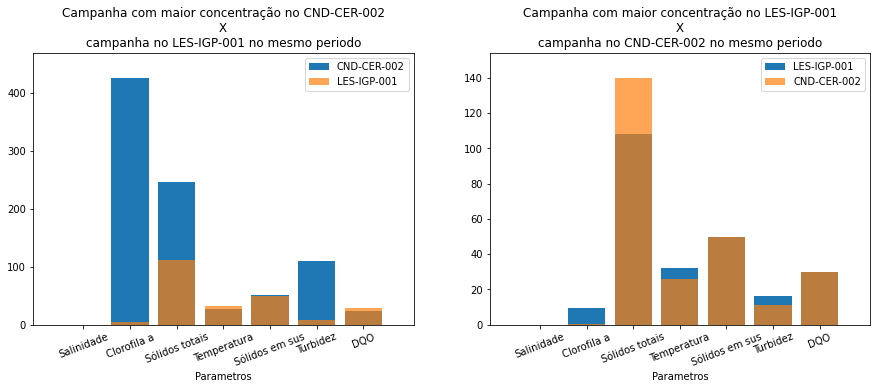

In [280]:


if compare == 'Interval': 
    lineGraph(url, parameter1,  interval, reservoir)

if compare == 'Reservoirs': 
    compareReservoirs([url1, url2], reservatory1, reservatory2, parameter1, interval)
    
elif compare == 'Parameters':
    compareParameter(url, [parameter1, parameter2], reservoir, interval)

elif compare == 'MostConcentradeCompaign': 
    graphCompareMoreConcentrated([url1, url2], reservatory1, reservatory2, interval, 'Clorofila a')